In [432]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import os
import xarray as xr
from scipy.interpolate import interp2d
import scipy.optimize as sp

# define constants
m_u = 1.6605402*(10**(-27))
c = 2.99792458*(10**10)
E_h = 4.35974*(10**(-18))
Angstrom = 10**(-10)

In [345]:
def extract(dir):
    '''
    Input a directory of gaussian output files

    Returns an xarray DataArray object of energies with bond length and angle
    as coordinates

    The length and angle data are taken from the file name as this is easier +
    runs slightly quicker, but for files where the indices don't line up this
    would need to be changed
    '''

    # Parameters extracted from file names
    bLen = list()
    bAngle = list()
    for FileName in os.listdir(dir):
        n = FileName.split("theta")
        bLen.append(float(n[0][5:]))
        bAngle.append(float(n[1][:-4]))

    # unique function collapses arrays to only unique values and orders them
    bLen = np.unique(bLen)
    bAngle = np.unique(bAngle)
    
    # create xarray object to contain energies
    fill_array = np.zeros((len(bLen),len(bAngle)))
    E = xr.DataArray(
        data = fill_array,
        name=dir[:3],
        dims = ['Bond_length','Bond_angle'],
        coords=(
            ('Bond_length',bLen),
            ('Bond_angle',bAngle),
    ),
        attrs=dict(
            description=f'{dir} energy data with bond length and angle',
            length_unit='Angstrom',
            angle_unit='Degrees'
            )
    )

    # Parse each file and fill output array with energies
    for FileName in os.listdir(dir):
        n = FileName.split("theta")    
        length = float(n[0][5:])
        angle = float(n[1][:-4])

        RawText = open(f"{dir}/{FileName}","r")
        for line in RawText:
            if "SCF Done:" in line:
                l = line.split()
                E.loc[length,angle] = l[4]
    print(dir + ' energies extracted')
    return E

In [457]:
# Extract data and show resulting array
h2o = extract('H2Ooutfiles')
h2o

H2Ooutfiles energies extracted


<xarray.DataArray 'H2O' (Bond_length: 25, Bond_angle: 91)>
array([[-75.70705381, -75.71098123, -75.71476669, ..., -75.75718054,
        -75.75649832, -75.75583763],
       [-75.82565047, -75.82920916, -75.83264039, ..., -75.86307975,
        -75.86234643, -75.86163664],
       [-75.90266778, -75.90588792, -75.90899346, ..., -75.9281185 ,
        -75.92733343, -75.92657377],
       ...,
       [-75.65176775, -75.65070124, -75.64972418, ..., -75.59265557,
        -75.59146892, -75.59029019],
       [-75.63479769, -75.6334978 , -75.6322907 , ..., -75.57549356,
        -75.57440964, -75.573335  ],
       [-75.61899215, -75.6174709 , -75.61604301, ..., -75.55934498,
        -75.55837478, -75.55741546]])
Coordinates:
  * Bond_length  (Bond_length) float64 0.7 0.75 0.8 0.85 ... 1.75 1.8 1.85 1.9
  * Bond_angle   (Bond_angle) float64 70.0 71.0 72.0 73.0 ... 158.0 159.0 160.0
Attributes:
    description:  H2Ooutfiles energy data with bond length and angle
    length_unit:  Angstrom
    angle_unit:   Degrees

In [455]:
h2s = extract('H2Soutfiles')

H2Soutfiles energies extracted


In [373]:
def plot(energy,bound):
    '''
    Takes the xarray object from the extract function and a bound variable,
    
    The bound variable sets the fraction of the standard deviation a value can 
    be away from the minimum to be included in the reduced matrix
    
    Outputs a plot of the whole surface and a heatmap of the minimum
    '''
    E_min = energy.min()
    E_std = energy.std()

    reduced = energy.where(energy<=E_min+(E_std*bound),drop=True)
    reduced = energy.loc[reduced.Bond_length,reduced.Bond_angle]
    # Plot the energies across the degrees of freedom
    fig = plt.figure(figsize=(10,5),dpi=400)

    ## Plotting
    # Plot subset nearer to minimum
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Bond angle / ' + chr(176))
    ax1.set_ylabel('r / Angstrom')
    ax1.set_title('View of minimum as a heatmap')

    c1 = ax1.pcolormesh(reduced.Bond_angle,reduced.Bond_length,reduced,cmap='RdBu_r',edgecolors='black',linewidth=0.25,vmin=energy.min(),vmax=energy.max())
    # fig.colorbar(c1,ax=ax1,shrink=0.5,aspect=5,location='right',pad=0.025)
    ax1.azim = 0
    ax1.elev = 25


    # Plot full data
    ax = fig.add_subplot(122,projection='3d')
    ax.set_xlabel('Bond angle / ' + chr(176))
    ax.set_ylabel('r / Angstrom')
    ax.set_zlabel('Energy / Hartree')
    ax.set_title('Energy surface of ' + energy.name)
    x,y = np.meshgrid(energy.Bond_angle,energy.Bond_length)

    surf = ax.plot_surface(x,y,energy,cmap='RdBu_r',edgecolors='black',linewidth=0.25)
    fig.colorbar(c1,ax=ax,shrink=0.5,aspect=5,location='right',pad=0.025,label='Energy / Hartree')
    ax.azim = 10
    ax.elev = 32
    return reduced

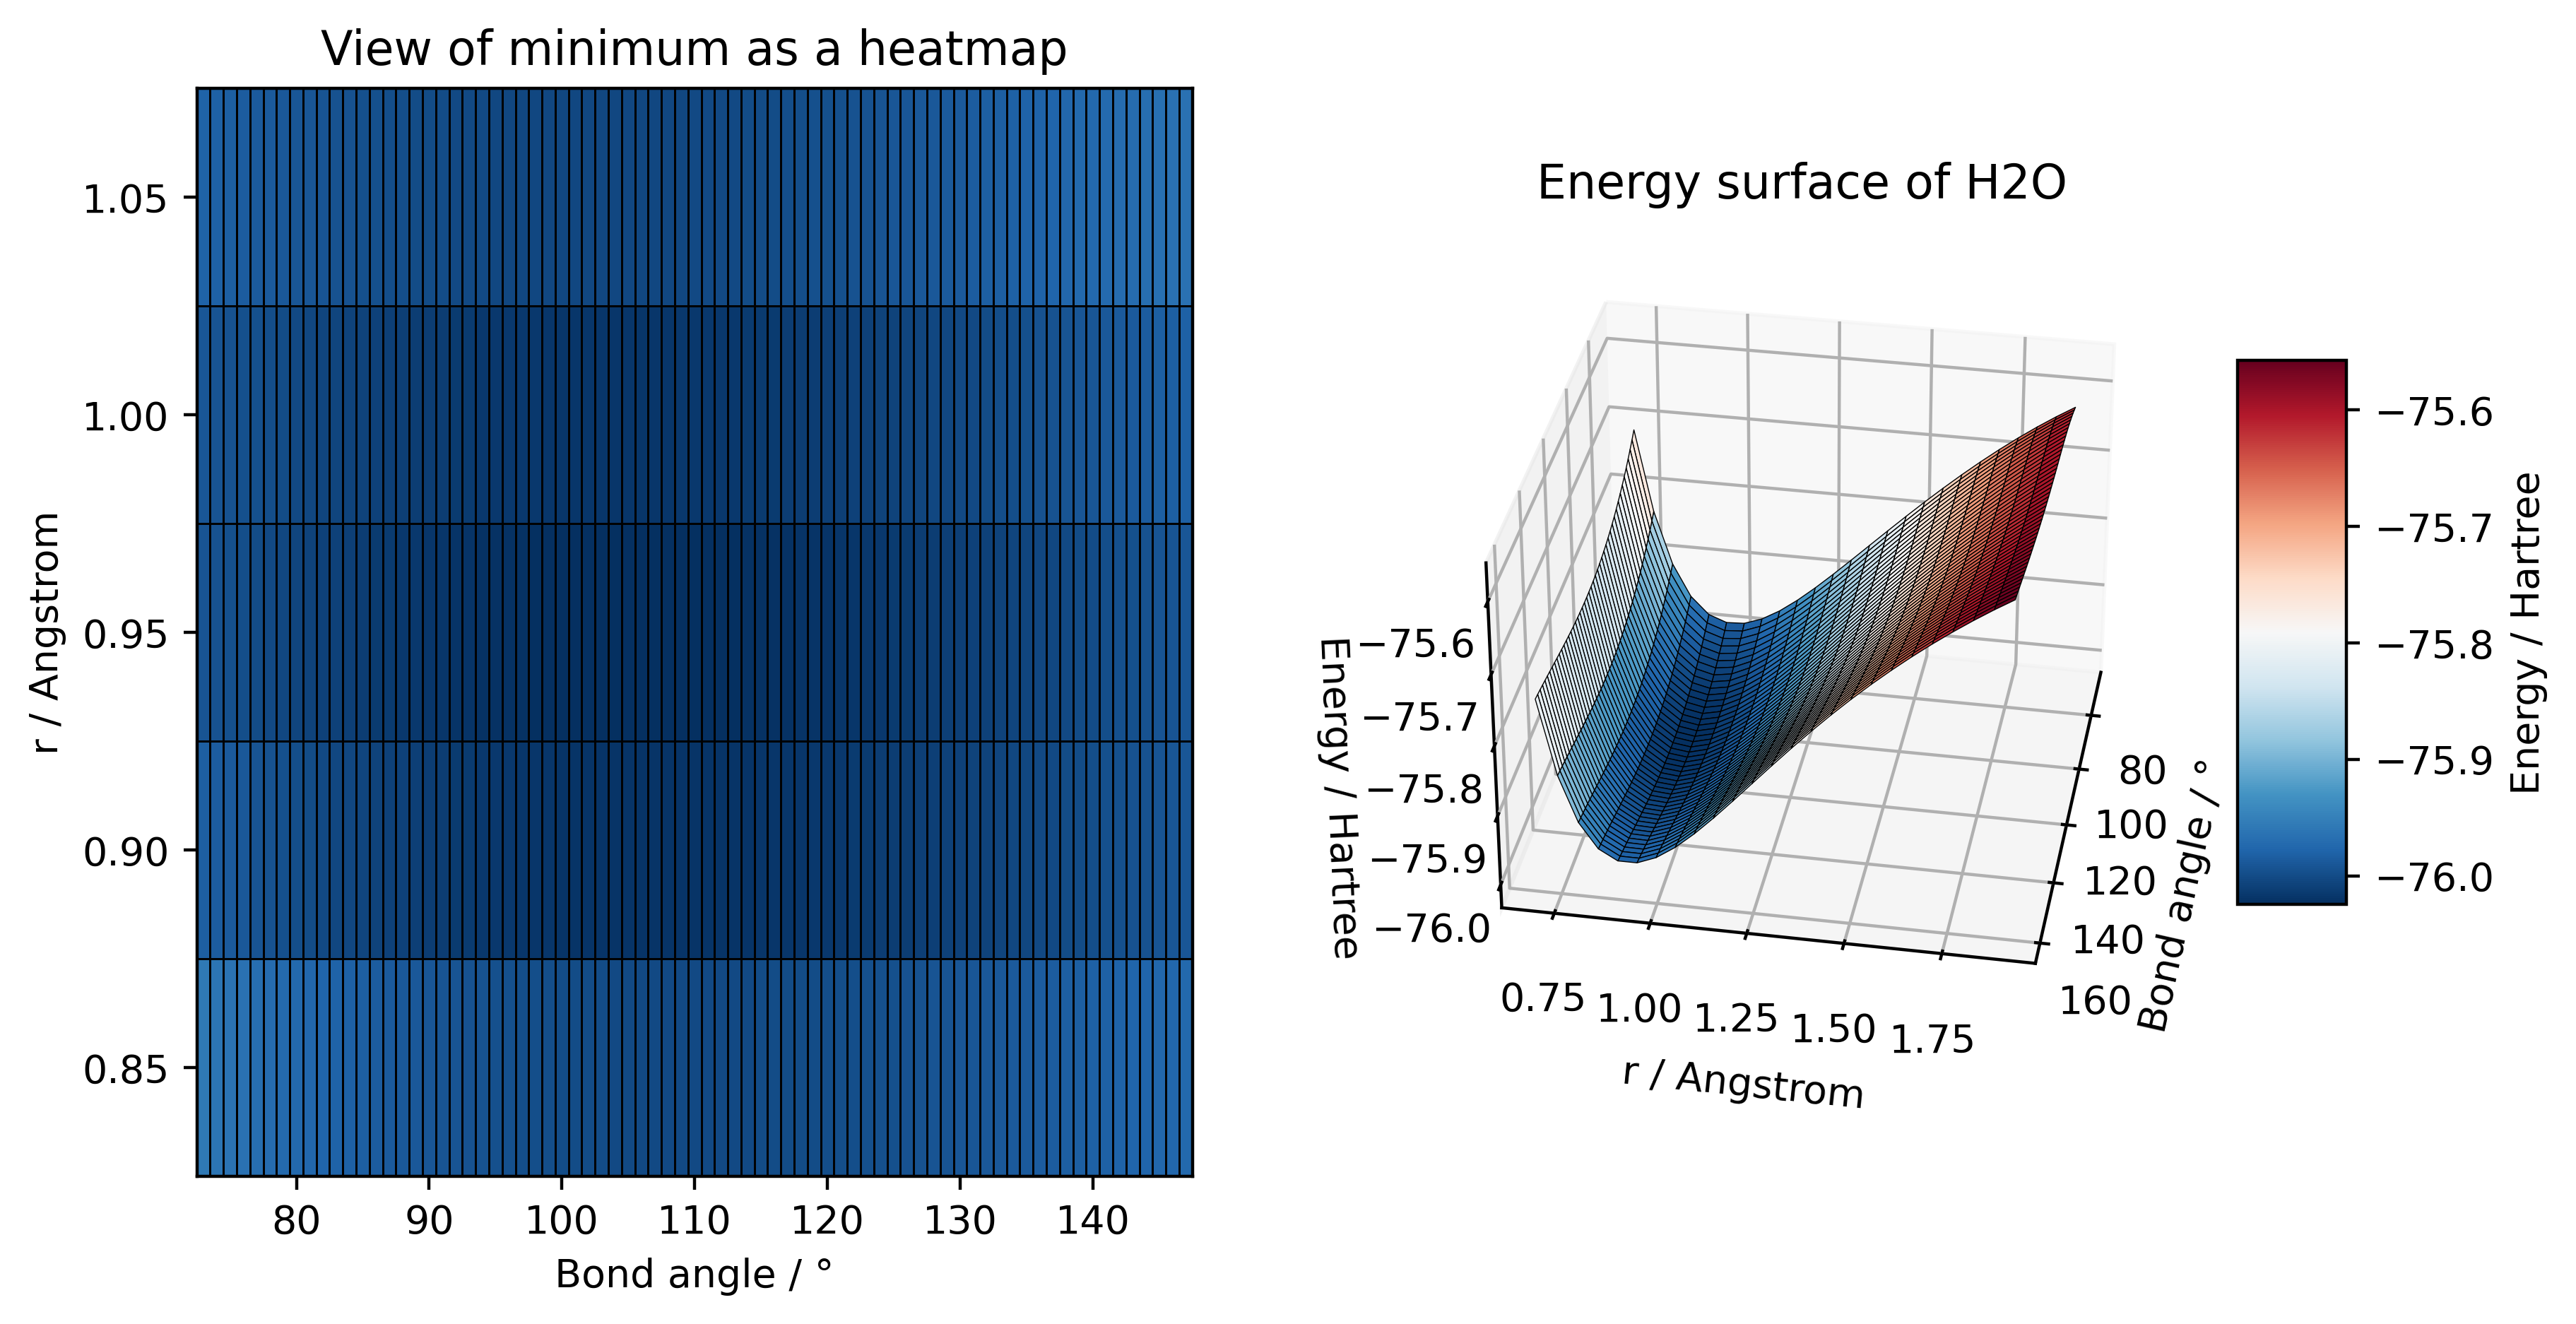

In [458]:
red = plot(h2o,0.25)

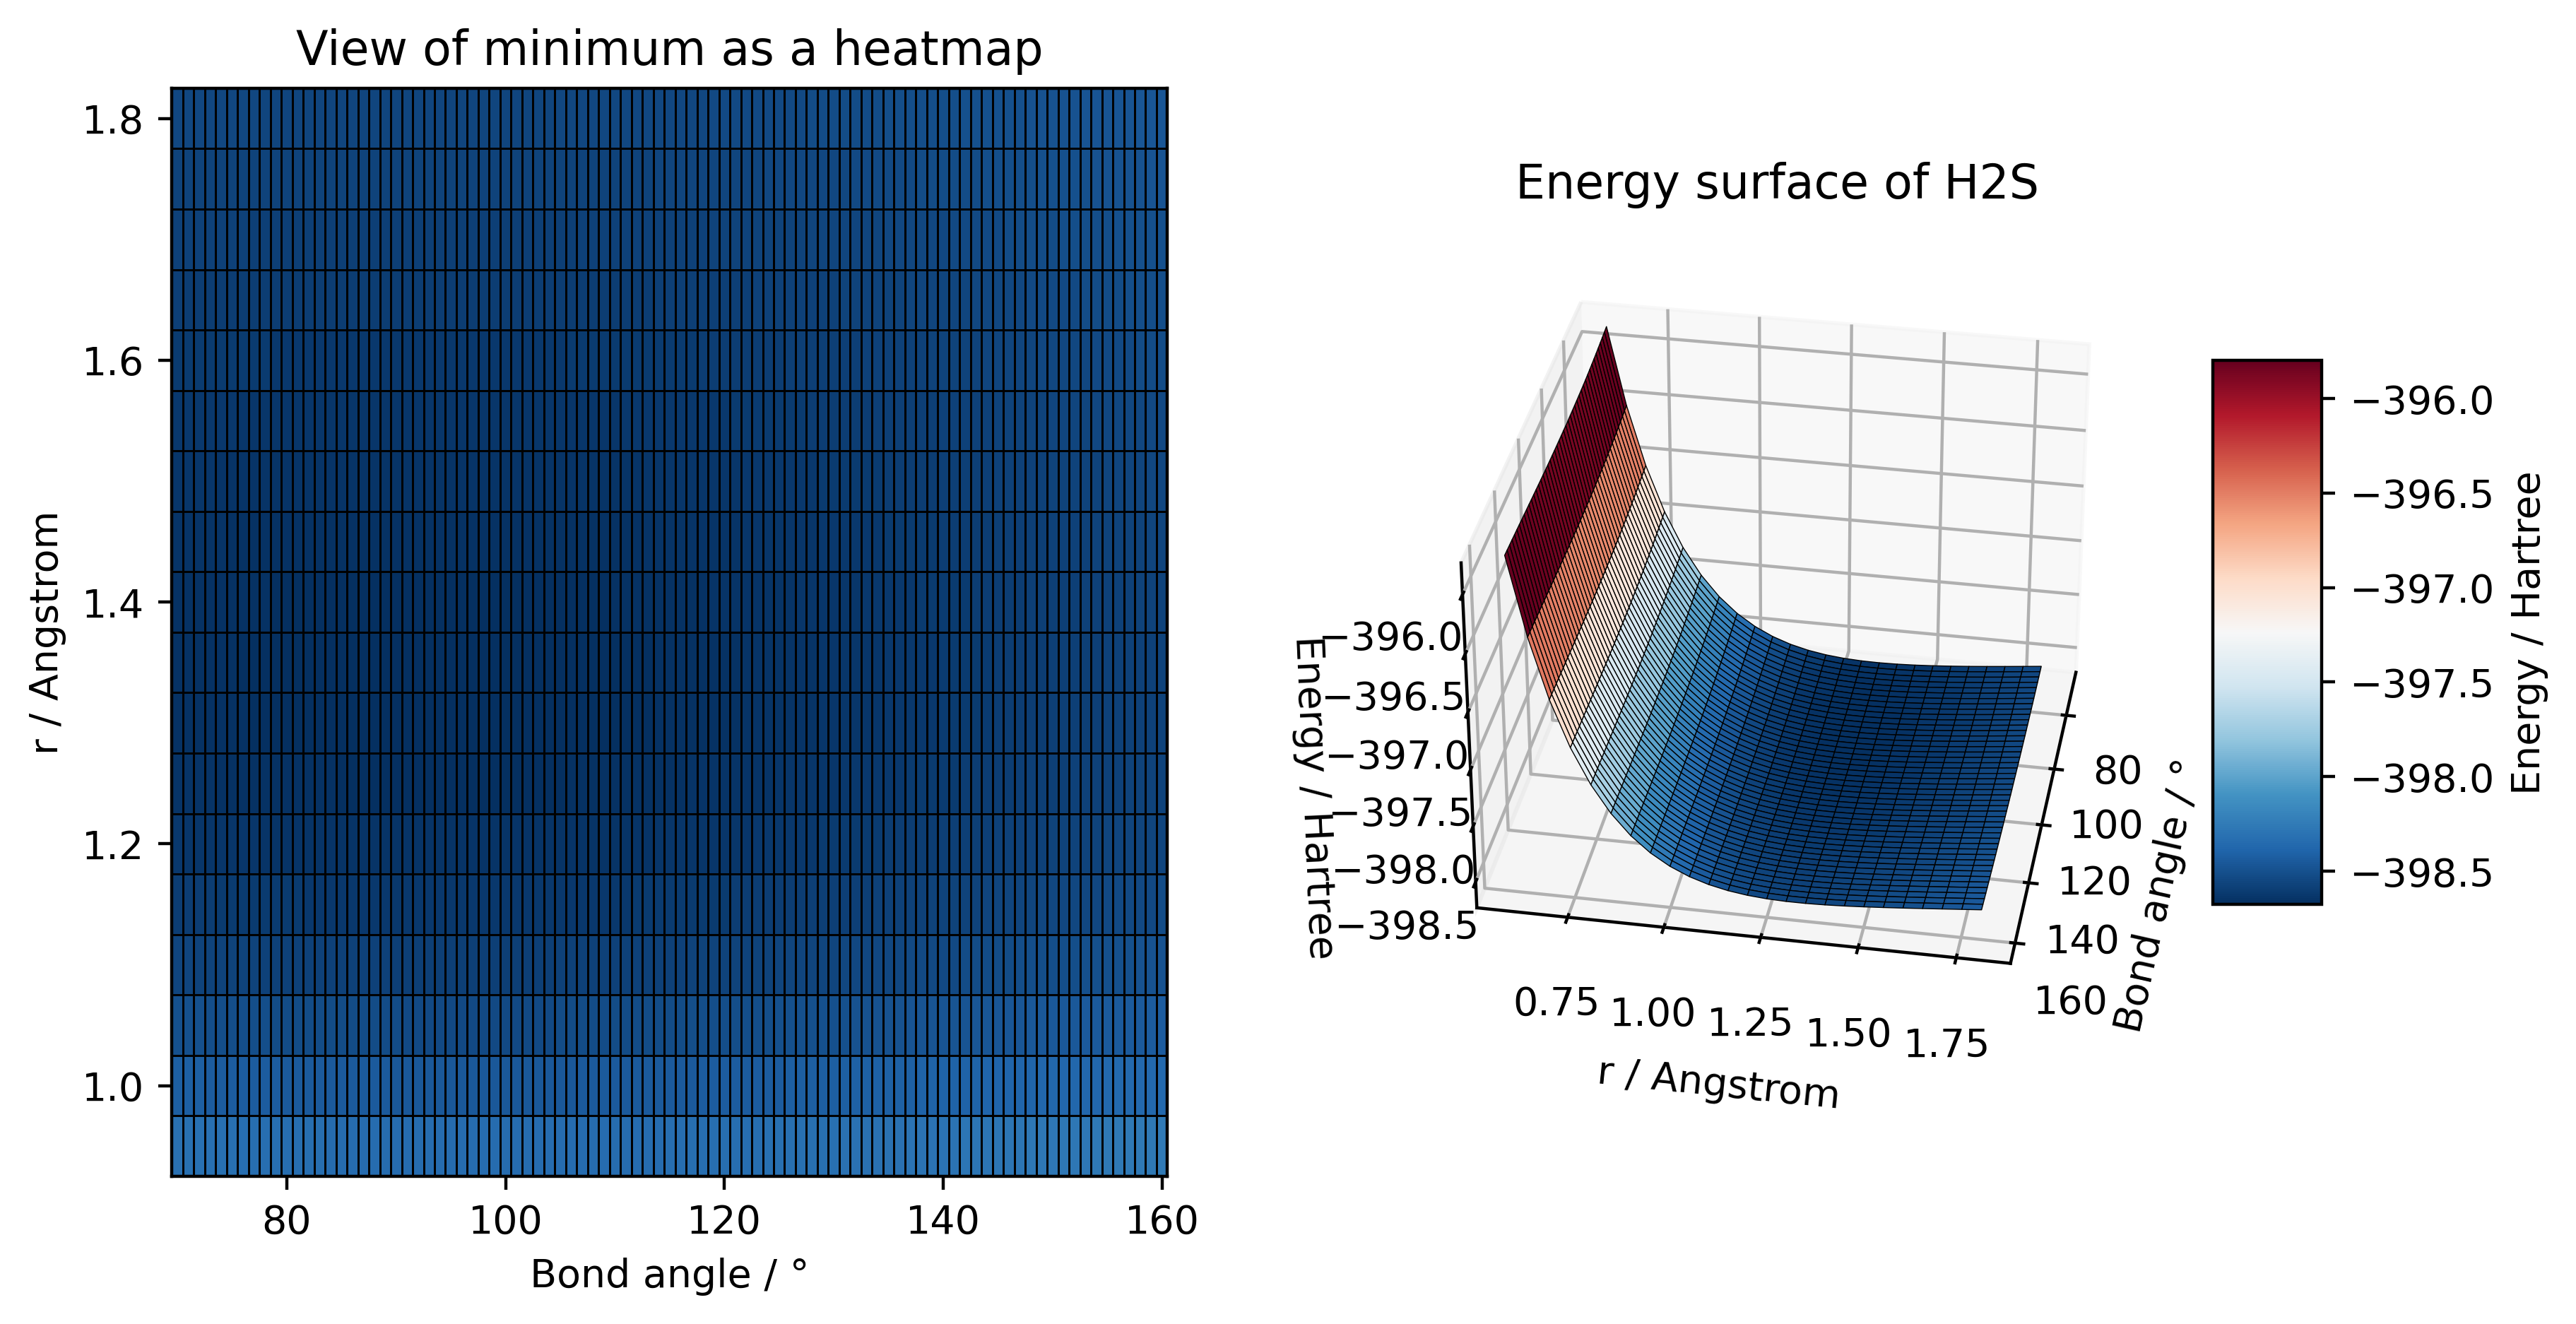

In [451]:
red1 = plot(h2s,0.5)

In [470]:
def hz_to_cm(freq_hz):
    return freq_hz/c

def calc_freq(energy):
    ''' 
    Calculate minmum parameters using a fitted interpolation function from
    a matrix of the energies in bond length/angle space

    Returns and prints a scipy.optimize object 
    '''
    ### Determine equilibrium
    # fit function to surface
    surf_eq = interp2d(energy.Bond_angle,energy.Bond_length,energy,kind='cubic')

    def fitfunc(babl):
        ba,bl = babl
        return surf_eq(ba,bl)

    # Create initial guess for minimization from minimum measured value
    idxmin = energy.argmin(('Bond_length','Bond_angle'))
    guess = [energy.Bond_length[idxmin['Bond_length']].data,energy.Bond_angle[idxmin['Bond_angle']].data]

    # Minimize surface to find equilibrium values
    equil = sp.fmin(fitfunc,guess)
    print('[Bond length / A, Bond Angle / Degree]\n' + str(equil))
    

    ### Determine parameters
    # convert indices in energy matrix using equilibrium values (Also unit conv)
    r_values = (energy.Bond_length - equil[0])*10**(-10)
    theta_values = np.deg2rad(energy.Bond_angle - equil[1])

    # E_r = E_h*np.array(energy.loc[slice(energy.Bond_length.min(),energy.Bond_length.max()),equil[1]])
    E_r = E_h*np.array(energy.loc[:,equil[1]])

    E_theta = E_h*np.array(energy.loc[equil[0],:])

    # Fit function parameters to data
    r_param = np.polyfit(r_values,E_r,2)
    theta_param = np.polyfit(theta_values,E_theta,2)

    k_r = r_param[0]*2
    k_theta = theta_param[0]*2
    
    v_1 = np.multiply(1/(2*np.pi),np.sqrt(k_r/(2*m_u)))
    v_2 = np.multiply(1/(2*np.pi),np.sqrt(k_theta/(0.5*m_u*((equil[0]*Angstrom)**2))))

    v_1 = hz_to_cm(v_1)
    v_2 = hz_to_cm(v_2)
    return k_r,k_theta,v_1,v_2




In [471]:
out = calc_freq(red)

Optimization terminated successfully.
         Current function value: -75.979755
         Iterations: 17
         Function evaluations: 67
[Bond length / A, Bond Angle / Degree]
[  0.95 105.  ]


In [472]:
out

(1926.9395070199043,
 6.79336201773432e-19,
 4043.838236378052,
 1598.484773335195)

In [473]:
out1 = calc_freq(red1)
out1

Optimization terminated successfully.
         Current function value: -398.546317
         Iterations: 17
         Function evaluations: 67
[Bond length / A, Bond Angle / Degree]
[ 1.35 94.  ]


(1056.1938274021584,
 6.856479790057366e-19,
 2993.860404138306,
 1130.07316250718)